In [96]:
from pathlib import Path
from numpy import array
from tensorflow import squeeze
from tensorflow.image import crop_and_resize
from tensorflow.io import decode_png, read_file

generator_glob = Path().glob('datasets/**/*.png')
ndarray_png = array(
    [
        squeeze(
            # (y1, x1, y2, x2)
            crop_and_resize((decode_png(read_file(str(path)), 1),), ((.21, .48, .86, .71),), (0,), (300, 300))
        ) for path in generator_glob
    ]
)
ndarray_png.shape

(899, 300, 300)

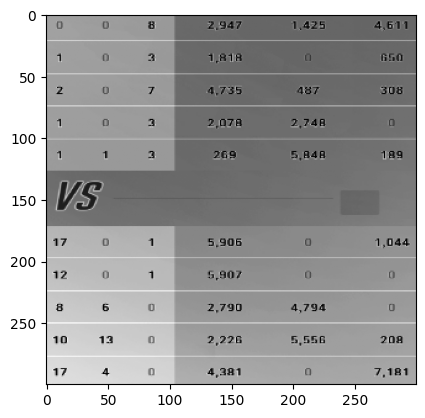

In [97]:
from matplotlib.pyplot import imshow, show

imshow(ndarray_png[0], 'binary')
show()

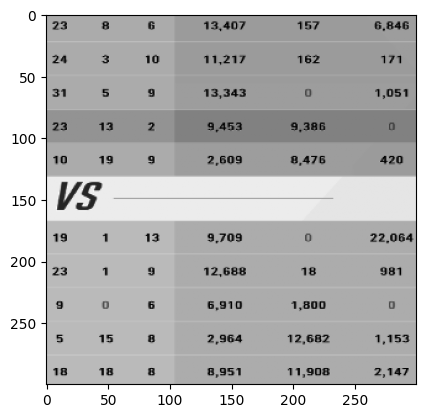

In [98]:
imshow(ndarray_png[-1], 'binary')
show()

In [99]:
import pandas as pd
from pandas import read_csv
from pandas import DataFrame

index_col = 0
usecols = 0, 2, 3, 4, 5, 6, 7
frame_csv = pd.concat(
    (
        read_csv('datasets/role_defeat.csv', index_col=index_col, usecols=usecols),
        read_csv('datasets/role_draw.csv', index_col=index_col, usecols=usecols),
        read_csv('datasets/role_victory.csv', index_col=index_col, usecols=usecols)
    ),
    keys=['defeat', 'draw', 'victory']
)
frame_column = DataFrame()
for str_column in frame_csv.columns:
    for i in range(len(str(frame_csv[str_column].max())) - 1, -1, -1):
        frame_column[f'{str_column}{i}'] = frame_csv[str_column] // 10 ** i % 10
frame_column.loc['defeat', 1]

E1  E0  A1  A0  D1  D0  DMG4  DMG3  DMG2  DMG1  ...  H4  H3  H2  \
       INDEX                                                  ...               
defeat 1       0   0   0   0   0   8     0     2     9     4  ...   0   1   4   
       1       0   1   0   0   0   3     0     1     8     1  ...   0   0   0   
       1       0   2   0   0   0   7     0     4     7     3  ...   0   0   4   
       1       0   1   0   0   0   3     0     2     0     7  ...   0   2   7   
       1       0   1   0   1   0   3     0     0     2     6  ...   0   5   8   
       1       1   7   0   4   0   0     0     4     3     8  ...   0   0   0   
       1       1   7   0   0   0   1     0     5     9     0  ...   0   0   0   
       1       1   2   0   0   0   1     0     5     9     0  ...   0   0   0   
       1       0   8   0   6   0   0     0     2     7     9  ...   0   4   7   
       1       1   0   1   3   0   0     0     2     2     2  ...   0   5   5   

              H1  H0  MIT4  MIT3  MIT2  MIT1  MIT0  
       INDEX                                        
defeat 1       2   5     0     4     6     1     1  
       1       0   0     0     0     6     5     0  
       1       8   7     0     0     3     0     8  
       1       4   8     0     0     0     0     0  
       1       4   8     0     0     1     8     9  
       1       0   0     0     7     1     8     1  
       1       0   0     0     1     0     4     4  
       1       0   0     0     0     0     0     0  
       1       9   4     0     0     0     0     0  
       1       5   6     0     0     2     0     8  

[10 rows x 21 columns]

In [100]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(ndarray_png.reshape(-1, 1)).reshape(-1, 300, 300)
int_outputs = 210
y = frame_column.values.reshape(-1, int_outputs).T
int_slice = -10
X_train, y_train = X[:int_slice], y[:, :int_slice]
X_valid, y_valid = X[int_slice:], y[:, int_slice:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((889, 300, 300), (210, 889), (10, 300, 300), (210, 10))

In [101]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense

clear_session()
inputs = Input(X_train.shape[1:])
flatten = Flatten()(inputs)
dense_1 = Dense(300, 'relu')(flatten)
dense_2 = Dense(100, 'relu')(dense_1)
outputs = tuple(Dense(10, 'softmax', name=f'dense_3_{i}')(dense_2) for i in range(1, int_outputs + 1))
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 90000)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │ 27,000,300 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     30,100 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_1 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_2 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_3 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_4 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_5 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_6 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_7 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_8 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_9 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_10 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_11 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_12 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_13 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_14 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_15 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_16 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_17 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_18 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_19 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_20 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 27,242,500 (103.92 MB)

 Trainable params: 27,242,500 (103.92 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
from tensorflow.keras.callbacks import Callback


class LossLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        total_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        print(f'Epoch {epoch + 1} - loss: {total_loss:.4f}', end='')
        if val_loss is not None:
            print(f' - val_loss: {val_loss:.4f}')
        else:
            print()

In [110]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile('SGD', 'sparse_categorical_crossentropy')
history = model.fit(
    X_train,
    tuple(y_train),
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), LossLogger()),
    validation_data=(X_valid, tuple(y_valid))
)

Epoch 1 - loss: 289561.1562 - val_loss: 769.8226
Epoch 2 - loss: 433.4046 - val_loss: 405.4547
Epoch 3 - loss: 391.8054 - val_loss: 392.9038
Epoch 4 - loss: 379.8725 - val_loss: 379.2471
Epoch 5 - loss: 366.4183 - val_loss: 364.4460
Epoch 6 - loss: 353.1205 - val_loss: 352.4117
Epoch 7 - loss: 342.7090 - val_loss: 343.6541
Epoch 8 - loss: 335.8300 - val_loss: 338.3891
Epoch 9 - loss: 331.4952 - val_loss: 334.8082
Epoch 10 - loss: 328.8998 - val_loss: 333.9185
Epoch 11 - loss: 327.3789 - val_loss: 332.9321
Epoch 12 - loss: 326.4122 - val_loss: 332.0509
Epoch 13 - loss: 325.9314 - val_loss: 332.2985
Epoch 14 - loss: 325.5329 - val_loss: 331.3341
Epoch 15 - loss: 325.2749 - val_loss: 331.3299
Epoch 16 - loss: 325.1043 - val_loss: 330.7718
Epoch 17 - loss: 324.9783 - val_loss: 330.6943
Epoch 18 - loss: 324.8997 - val_loss: 331.0661
Epoch 19 - loss: 324.7931 - val_loss: 330.6671
Epoch 20 - loss: 324.7160 - val_loss: 330.4212
Epoch 21 - loss: 324.6280 - val_loss: 330.4259
Epoch 22 - loss: 32

In [111]:
from numpy import array

y_proba = array(model.predict(X_valid[:1])).argmax(2).reshape(10, 21)
y_proba

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[1, 6, 0, 3, 0, 5, 0, 7, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 7, 4],
       [1, 2, 0, 0, 0, 3, 0, 7, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 8, 0, 9, 5, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 4, 0, 5, 0, 3, 0, 4, 0, 0, 8, 1, 2, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 3, 0, 5, 0, 3, 0, 0, 0, 0, 5, 6, 2, 7, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 5, 0, 0, 0, 9, 1, 0, 0, 0, 0, 0, 0, 5, 8, 2, 4],
       [1, 5, 0, 0, 0, 7, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 1, 3, 0, 5, 0, 2, 0, 0, 0, 0, 6, 1, 4, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 4, 0, 6, 0, 2, 0, 0, 0, 0, 6, 0, 7, 3, 0, 0, 0, 0, 0]])

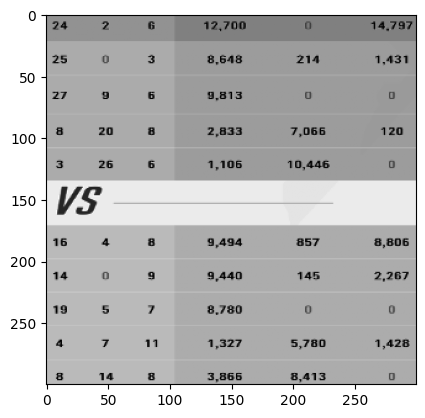

In [112]:
imshow(X_valid[0], 'binary')
show()

In [117]:
y_valid[:, 0].reshape(10, 21)

array([[2, 4, 0, 2, 0, 6, 1, 2, 7, 0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 7],
       [2, 5, 0, 0, 0, 3, 0, 8, 6, 4, 8, 0, 0, 2, 1, 4, 0, 1, 4, 3, 1],
       [2, 7, 0, 9, 0, 6, 0, 9, 8, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 8, 2, 0, 0, 8, 0, 2, 8, 3, 3, 0, 7, 0, 6, 6, 0, 0, 1, 2, 0],
       [0, 3, 2, 6, 0, 6, 0, 1, 1, 0, 6, 1, 0, 4, 4, 6, 0, 0, 0, 0, 0],
       [1, 6, 0, 4, 0, 8, 0, 9, 4, 9, 4, 0, 0, 8, 5, 7, 0, 8, 8, 0, 6],
       [1, 4, 0, 0, 0, 9, 0, 9, 4, 4, 0, 0, 0, 1, 4, 5, 0, 2, 2, 6, 7],
       [1, 9, 0, 5, 0, 7, 0, 8, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 7, 1, 1, 0, 1, 3, 2, 7, 0, 5, 7, 8, 0, 0, 1, 4, 2, 8],
       [0, 8, 1, 4, 0, 8, 0, 3, 8, 6, 6, 0, 8, 4, 1, 3, 0, 0, 0, 0, 0]])